In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats.stats import kendalltau
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# <a id="code0">Inferential Statistics</a>

## Classification Feature Selection

### <a id="code1">Univariate Selection scikit-learn library SelectKBest class</a>

In [7]:
#Top_250/500
df_full = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted.csv')
df_fs = df_full.loc[df_full['Ranking'] <= 1500].copy() # 500/1500
df_fs.loc[(df_fs['Ranking'] <= 250), 'Top_250'] = 1
df_fs.loc[(df_fs['Ranking'] > 250), 'Top_250'] = 0
df_fs.loc[(df_fs['Ranking'] <= 500), 'Top_500'] = 1
df_fs.loc[(df_fs['Ranking'] > 500), 'Top_500'] = 0

X = df_fs[['Hotel', 'Tourism', 'Cafe', 'Pub', 'Museum', 'Restaurant', 'University',
       'Luas', 'Company', 'Liffey', 'Price Area']]
y = df_fs['Top_500'] # Top_250/Top_500

#chi2: Chi-squared stats of non-negative features for classification tasks.
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores_1 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_1.columns = ['Feature','chi2_Score'] 

#f_classif: ANOVA F-value between label/feature for classification tasks.
bestfeatures = SelectKBest(score_func=f_classif, k=11)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores_2 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_2.columns = ['Feature','f_classif_Score'] 

#f_regression: F-value between label/feature for regression tasks.
bestfeatures = SelectKBest(score_func=f_regression, k=11)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores_3 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_3.columns = ['Feature','f_regression_Score'] 

#merging the data into one dataframe
featureScores_temp = pd.merge(featureScores_1, featureScores_2, on='Feature')
featureScores = pd.merge(featureScores_temp, featureScores_3, on='Feature')

In [8]:
featureScores

,Feature,chi2_Score,f_classif_Score,f_regression_Score
0,Hotel,8.076303,21.253377,21.253377
1,Tourism,7.423295,17.346446,17.346446
2,Cafe,7.307848,20.222865,20.222865
3,Pub,11.973082,26.230926,26.230926
4,Museum,8.493689,21.403030,21.403030
5,Restaurant,10.892682,25.402042,25.402042
6,University,10.147394,20.746196,20.746196
7,Luas,0.670894,1.021021,1.021021
8,Company,1.788143,4.985856,4.985856
9,Liffey,4.347397,6.373502,6.373502


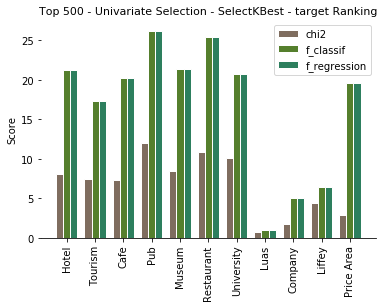

In [9]:
#Top_250/500
barWidth = 0.25
bars1 = list(featureScores.iloc[:,1].round(2))
bars2 = list(featureScores.iloc[:,2].round(2))
bars3 = list(featureScores.iloc[:,3].round(2))
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='chi2')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='f_classif')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='f_regression')

plt.ylabel('Score')
plt.xticks([r + barWidth for r in range(len(bars1))], list(featureScores.Feature), rotation=90)
plt.title('Top 500 - Univariate Selection - SelectKBest - target Ranking', fontsize=11)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.legend()
plt.savefig('charts/SelectKBest_Ranking_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code2">Feature Importance - ExtraTreesClassifier</a>

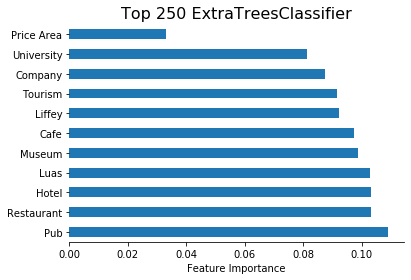

In [10]:
#Top_250/500
df_NOR = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted_with_mean_True.csv') # needs median zero
df_fi = df_NOR.loc[df_NOR['Ranking'] <= 500].copy() # 500/1500
df_fi.loc[(df_fi['Ranking'] <= 250), 'Top_250'] = 1
df_fi.loc[(df_fi['Ranking'] > 250), 'Top_250'] = -1
df_fi.loc[(df_fi['Ranking'] <= 500), 'Top_500'] = 1
df_fi.loc[(df_fi['Ranking'] > 500), 'Top_500'] = -1

X = df_fi[['Hotel', 'Tourism', 'Cafe', 'Pub', 'Museum', 'Restaurant', 'University',
       'Luas', 'Company', 'Liffey', 'Price Area']]
y = df_fi['Top_250']

model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top 250 ExtraTreesClassifier', fontsize=16)
plt.savefig('charts/Top_250_ExtraTreesClassifier.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code3">Correlation Matrix with Heatmap - method Kendall</a>

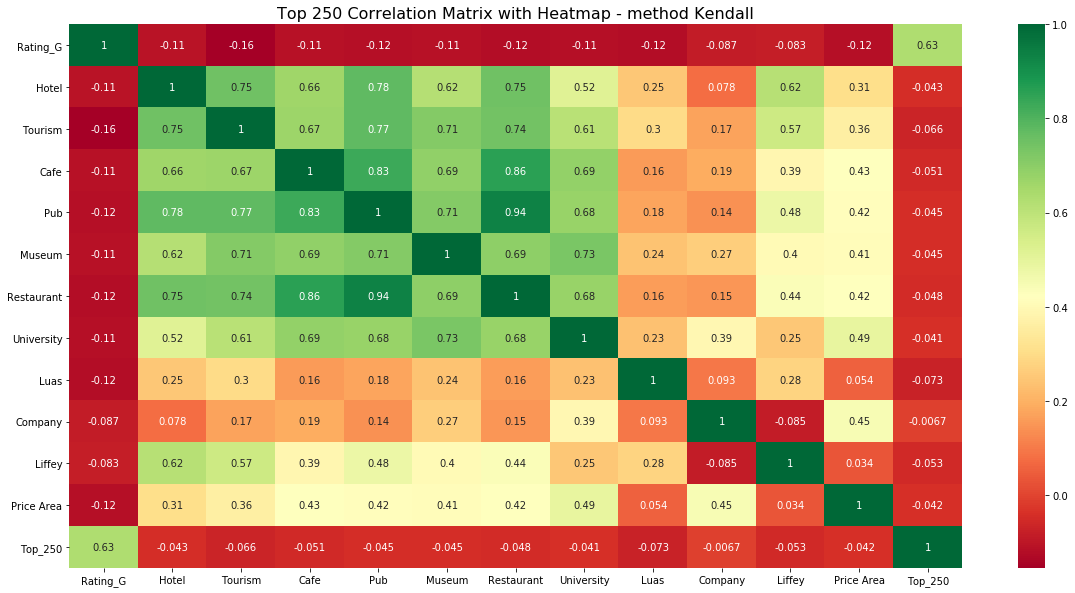

In [14]:
#Top_250/500
df_NOR = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted_with_mean_True.csv')
df_cm = df_NOR.loc[df_NOR['Ranking'] <= 500].copy() # 500/1500
df_cm.loc[(df_cm['Ranking'] <= 250), 'Top_250'] = 1
df_cm.loc[(df_cm['Ranking'] > 250), 'Top_250'] = -1
#df_cm.loc[(df_cm['Ranking'] <= 500), 'Top_500'] = 1
#df_cm.loc[(df_cm['Ranking'] > 500), 'Top_500'] = -1
data = df_cm.iloc[:,12:]
corrmat = data.corr(method='kendall')
top_corr_features = corrmat.index
plt.figure(figsize=(20,10))
plt.title('Top 250 Correlation Matrix with Heatmap - method Kendall', fontsize=16)
sns.heatmap(data[top_corr_features].corr(method='kendall'),annot=True,cmap="RdYlGn")
plt.savefig('charts/Top_250_Correlation_Matrix_kendall.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

For uncorrelated features, the optimal feature size is N-1 (N sample size)<br>
As feature correlation increases, the optimal feature size is proportional to √(N) for highly correlated features<br>
source:
https://academic.oup.com/bioinformatics/article/21/8/1509/249540

However, a rule of thumb for a dataset of N samples would be N/10 features

### <a id="code4">Pearson Correlation / REF / Lasso / Random Forest / Light Gradient Boosted Machine</a>

In [4]:
df_NOR = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted_with_mean_True.csv')
# adapted from https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2
#Top_250/500
num_feats=6
df_fi = df_NOR.loc[df_NOR['Ranking'] <= 1500].copy() # 500/1500
df_fi.loc[(df_fi['Ranking'] <= 250), 'Top_250'] = 1
df_fi.loc[(df_fi['Ranking'] > 250), 'Top_250'] = -1
df_fi.loc[(df_fi['Ranking'] <= 500), 'Top_500'] = 1
df_fi.loc[(df_fi['Ranking'] > 500), 'Top_500'] = -1

X = df_fi[['Hotel', 'Tourism', 'Cafe', 'Pub', 'Museum', 'Restaurant', 'University',
       'Luas', 'Company', 'Liffey', 'Price Area']]
y = df_fi['Top_500'] #Top_250/Top_500

# Pearson Correlation / Numerical Input, Numerical Output / Pearson’s correlation coefficient (linear)
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y, num_feats)

# Recursive Feature Elimination
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

# Lasso: SelectFromModel - Logistic Regression
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

# Tree-based: SelectFromModel - Random Forest Classifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

# LightGBM Classifier
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

# Feature classifiers comparison
feature_name = X.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'RFE':rfe_support, 
                    'Logistics':embeded_lr_support, 'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(11)

Fitting estimator with 11 features.


,Feature,Pearson,RFE,Logistics,Random Forest,LightGBM,Total
1,Pub,True,True,True,True,True,5
2,Hotel,True,True,True,True,True,5
3,Cafe,True,True,True,True,True,5
4,Restaurant,True,True,True,True,False,4
5,Museum,True,True,True,False,False,3
6,Luas,False,False,False,True,True,2
7,Liffey,False,False,False,True,True,2
8,University,True,False,False,False,False,1
9,Tourism,False,True,False,False,False,1
10,Company,False,False,False,False,True,1


### <center><a href="./D.Prediction_Models_SVM.ipynb#code0">NEXT CHAPTER</a></center>

#### <center> <a href="./0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>